# Import

In [1]:
import argparse
from datetime import datetime
import os
import subprocess
import re


def get_least_used_gpus(n=1):
    smi_output = subprocess.run(
        [
            "nvidia-smi",
            "--query-gpu=index,memory.free",
            "--format=csv,nounits,noheader",
        ],
        capture_output=True,
        text=True,
    )
    gpu_memory = [
        re.split(r",\s*", line.strip())
        for line in smi_output.stdout.strip().split("\n")
    ]
    least_used_gpus = sorted(gpu_memory, key=lambda x: int(x[1]), reverse=True)[:n]
    return [gpu[0] for gpu in least_used_gpus]


least_used_gpus = get_least_used_gpus(1)
print(f"Didn't specify devices, using least used GPUs: {', '.join(least_used_gpus)}")
os.environ["CUDA_VISIBLE_DEVICES"] = "".join(least_used_gpus)


import orbax
import orbax.checkpoint

from matplotlib import pyplot as plt
import jax
import jax.numpy as jnp
from functools import partial
from typing import Dict


import numpy as np

# set path
import sys

from dreamerv3_flax.buffer import ReplayBuffer

# from dreamerv3_flax.env import CrafterEnv, VecCrafterEnv, TASKS
from dreamerv3_flax.jax_agent import JAXAgent

from dreamerv3_flax.craftax import CraftaxWrapper
from flax.training import orbax_utils


def load_latest_checkpoint(buffer: ReplayBuffer, agent: JAXAgent, ckpt_filepath: str):
    step = 0
    achievements = []

    buffer_dict = {
        "obs": np.zeros_like(buffer.obs),
        "actions": np.zeros_like(buffer.actions),
        "rewards": np.zeros_like(buffer.rewards),
        "dones": np.zeros_like(buffer.dones),
        "firsts": np.zeros_like(buffer.firsts),
        "pos": 0,
        "full": False,
    }
    target = {
        "step": step,
        "agent_model_state": agent.model_state,
        "agent_policy_state": agent.policy_state,
        "buffer": buffer_dict,
        "achievements": achievements,
    }
    if not ckpt_filepath:
        # raise error
        raise ValueError("No checkpoint file path provided")
    else:
        print(f"Loading checkpoint from {ckpt_filepath}")
        return orbax_checkpointer.restore(ckpt_filepath, item=target)


orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

Didn't specify devices, using least used GPUs: 1


2024-08-29 13:31:30.075499: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Loading textures from cache.
Textures successfully loaded from cache.


# Settings

In [2]:
seed = 11
curious_replay = False
ckpt_filepath = "/home/alan/Craftax_Baselines/dreamerv3-flax/20240827-102852_ckpt_seed_0_step_1000000"
# steps_to_eval = 200
img_horizon = 200
sample = False


In [3]:
np.random.seed(seed)

envs = CraftaxWrapper(1)


buffer = ReplayBuffer(envs, batch_size=16, num_steps=64)

agent = JAXAgent(envs, seed=seed)
agent.agent.img_horizon = img_horizon
state = agent.initial_state(1)

state_restored = load_latest_checkpoint(buffer, agent, ckpt_filepath)
if state_restored:
    step, agent.model_state, agent.policy_state, buffer_dict, achievements = (
        state_restored["step"],
        state_restored["agent_model_state"],
        state_restored["agent_policy_state"],
        state_restored["buffer"],
        state_restored["achievements"],
    )

    (
        buffer.obs,
        buffer.actions,
        buffer.rewards,
        buffer.dones,
        buffer.firsts,
        buffer.pos,
        buffer.full,
    ) = (
        buffer_dict["obs"].copy(),
        buffer_dict["actions"].copy(),
        buffer_dict["rewards"].copy(),
        buffer_dict["dones"].copy(),
        buffer_dict["firsts"].copy(),
        buffer_dict["pos"],
        buffer_dict["full"],
    )

Loading checkpoint from /home/alan/Craftax_Baselines/dreamerv3-flax/20240827-102852_ckpt_seed_0_step_1000000


In [4]:
print(buffer_dict["obs"].shape, buffer_dict["obs"].dtype)
print(buffer_dict["actions"].shape, buffer_dict["actions"].dtype)
print(buffer_dict["rewards"].shape, buffer_dict["rewards"].dtype)
print(buffer_dict["dones"].shape, buffer_dict["dones"].dtype)
print(buffer_dict["firsts"].shape, buffer_dict["firsts"].dtype)

(500000, 1, 64, 64, 3) uint8
(500000, 1, 17) float32
(500000, 1) float32
(500000, 1) float32
(500000, 1) float32


# Run

In [5]:
obs, info = envs.reset()
actions = envs.action_space.sample()
obs, rewards, terminateds, truncateds, dones, infos = envs.step(actions)
firsts = jnp.ones_like(dones)
# obs, rewards, dones, firsts, infos = envs.step(actions)
# actions, state = agent.act(obs["rgb"], firsts, state) # policy action
actions = np.random.randint(1, 5, size=(1,))  # 4 direction random actions
post = state[0]

# define input to imagine
params = {**agent.model_state.params, **agent.policy_state.params}
stats = {**agent.model_state.stats, **agent.policy_state.stats}
variables = {"params": params, "stats": stats}
post_key, prior_key, action_key, key = jax.random.split(agent.key, 4)
rngs = {"post": post_key, "prior": prior_key, "action": action_key}
# traj = agent.agent.apply(
#     variables, post, sample, rngs=rngs, method=agent.agent.simple_imagine
# )  # policy action
key, _key = jax.random.split(key)
traj = agent.agent.apply(
    variables,
    post,
    _key,
    sample,
    rngs=rngs,
    method=agent.agent.simple_imagine_4_rnd_dir_act,
)  # 4 direction random actions


In [6]:
traj["action"][:, 1:5]

Array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],


In [7]:
traj["latent"].shape

(201, 5120)

In [8]:
obs_out = agent.agent.apply(
    variables, traj["latent"], rngs=rngs, method=agent.agent.simple_decode
)

In [9]:
obs_out.shape

(201, 64, 64, 3)

In [10]:
type(obs_out)

jaxlib.xla_extension.ArrayImpl

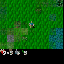

In [11]:
import jax.numpy as jnp
import numpy as np
import imageio
from io import BytesIO
from IPython.display import Image

# Convert JAX array to NumPy array if it's not already
obs_out_np = np.array(obs_out) - np.max(obs_out) + 1  # Ensure this is uint8 if needed

# If your image data is normalized (floats in [0, 1]), convert to uint8
obs_out_uint8 = (obs_out_np * 255).astype(np.uint8)

# Save GIF to the disk
imageio.mimsave("output.gif", obs_out_uint8, format="GIF", fps=10)

# To display the GIF in the notebook, read the saved GIF and display it
with open("output.gif", "rb") as f:
    display(Image(data=f.read(), format="gif"))


In [10]:
# see range in obs_out_np
np.min(obs_out_np), np.max(obs_out_np)

(Array(-0.16308594, dtype=float32), Array(1., dtype=float32))